In [1]:
import pandas as pd
import torch
import torchaudio
from b2aiprep.process import Audio, specgram, plot_spectrogram, plot_waveform

c:\Users\namac\.virtualenvs\b2ai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# active_slot_duration = 5 # in sec
# need_complete_audio = True
filter_label = "RP" # FIMO, RP, Deep, or empty
label_column = 'phonatory_status'  # Or 'stridor_status', 'status', 'phonatory_status', depending on your use case
# audio_sample_duration = active_slot_duration

# slider information
is_sliding_window_travel = True
traversal_window_frame = 3 # in sec
traversal_rate = 1 # in sec

# if need_complete_audio:
#     print("No need to split, just add padding")
#     if (len(filter_label)):
#         if filter_label == "FIMO":
#             audio_sample_duration = 13
#         elif filter_label == "RP":
#             audio_sample_duration = 30
#         elif filter_label == "Deep":
#             audio_sample_duration = 12
#     else:
#         audio_sample_duration = active_slot_duration
# else:
#     print("split into slots, and add padding")
#     audio_sample_duration = active_slot_duration

# print(f"final audio sample duration: {audio_sample_duration}")

In [3]:
from lib import generate_recording_objects, count_samples, filter_recordings_by_label, get_most_active_segment

In [4]:
# Usage
root_path = 'C:\\Users\\namac\\Studies\\B2AI\\STRIDOR FULL ANON-selected\\Data files'  # Replace with the actual path to your folders
excel_path = 'C:\\Users\\namac\\Studies\\B2AI\\Stridor_Labels.xlsx'  # Replace with the actual path to your Excel file
output_csv = 'rec_6_time.csv'  # Desired output CSV file name
output_json = 'rec_6_time.json'  # Desired output JSON file name

# Read the Excel file
patient_status_df = pd.read_excel(excel_path)

recordings = generate_recording_objects(root_path, patient_status_df, label_column)
print(f"Total samples: {len(recordings)}")

# Uncomment the following lines to save to CSV
# save_to_csv(recordings, output_csv)
# print(f"Recording objects have been saved to {output_csv}")

# Uncomment the following lines to save to JSON
# save_to_json(recordings, output_json)
# print(f"Recording objects have been saved to {output_json}")

# Count the samples
no_stridor_count, phonatory_count, non_phonatory_count = count_samples(recordings)
print(f"No-Stridor samples: {no_stridor_count}")
print(f"Phonatory samples: {phonatory_count}")
print(f"Non-Phonatory samples: {non_phonatory_count}")

Total samples: 620
No-Stridor samples: 270
Phonatory samples: 89
Non-Phonatory samples: 261


In [5]:
data = recordings.copy()
print(f"data count: {len(data)}")

# Filter recordings
if (len(filter_label)):
    filtered_data = filter_recordings_by_label(data, filter_label)
    data = filtered_data


print(f"filtered recordings count: {len(data)}")
# print(f"filtered recordings: {data}")

data count: 620
filtered recordings count: 95


In [6]:
# Prepare audio dataset
audio_data = []
for entry in data:
    # Calculate the traversal sliding slots
    # if there is any last block left, just reverse this and create extra slot

    row = entry.copy()
    travel_reminder = int(entry["duration"] % traversal_rate)
    
    audio_duration = entry["duration"]
    sr = 16000  # Assuming the sample rate is 16 kHz after resampling
    traversal_window_samples = traversal_window_frame * sr
    traversal_rate_samples = traversal_rate * sr
    
    # Load the full audio signal
    audio = Audio.from_file(entry["recording"]).to_16khz()
    y = audio.signal.squeeze(1)  # Ensure the tensor has the correct dimensions
    
    segments = []
    for start in range(0, len(y), traversal_rate_samples):
        end = start + traversal_window_samples
        if end <= len(y):
            segments.append(y[start:end])
        else:
            # Handle remaining audio at the end if any
            remaining_audio = y[-traversal_window_samples:]
            segments.append(remaining_audio)
            break
    
    for i, segment in enumerate(segments):
        if segment.shape[0] < traversal_window_samples:
            padding_needed = traversal_window_samples - segment.shape[0]
            segment = torch.nn.functional.pad(segment, (0, padding_needed))
        
        segment_audio = Audio(segment.unsqueeze(1), audio.sample_rate)
        segment_row = row.copy()
        segment_row["uid"] = f"{entry['uid']}-{i+1}"
        segment_row["duration"] = traversal_window_frame
        segment_row["audio_sample"] = segment_audio
        audio_data.append(segment_row)

In [7]:
print(f"audio_data: {len(audio_data)}")

audio_data: 3338


UID: 928d9dd0-bac8-4297-bc6d-54bd9d788009-5
Recording ID: 928d9dd0-bac8-4297-bc6d-54bd9d788009
Recording Label: RP12inch


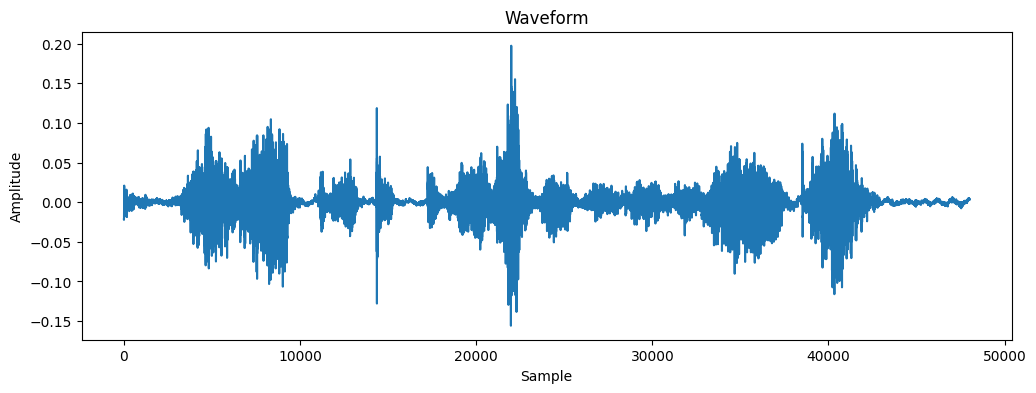

In [8]:
from lib import display_and_play_sample
index = 4  # Replace with the desired sample index
display_and_play_sample(audio_data, index)

In [9]:
class MySpecgramDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, label_column, num_classes, mel = False):
        self.dataframe = dataframe.copy()  # Copy to avoid modifying the original DataFrame
        self.label_column = label_column
        self.num_classes = num_classes
        self.mel = mel
        
        # Ensure the DataFrame has the necessary columns
        required_columns = ['uid', 'recording_id', 'name', 'recording_label', 'recording', 'audio_sample', label_column]
        for col in required_columns:
            if col not in dataframe.columns:
                raise ValueError(f"DataFrame is missing required column: {col}")
            
         # Store the unique labels and create a mapping
        self.unique_labels = list(self.dataframe[label_column].unique())
        self.label_to_index = {label: index for index, label in enumerate(self.unique_labels)}
        self.index_to_label = {index: label for label, index in self.label_to_index.items()}

        # Convert the label column to integer indices
        self.dataframe[label_column] = self.dataframe[label_column].map(self.label_to_index)

        # Extract necessary information from the DataFrame
        self.audio_files = dataframe['recording'].tolist()
        self.audio_samples = dataframe['audio_sample'].tolist()
        self.labels = self.dataframe[label_column].tolist()
        self.uids = dataframe['uid'].tolist()
        self.recording_labels = dataframe['recording_label'].tolist()
        self.recording_ids = dataframe['recording_id'].tolist()
        self.names = dataframe['name'].tolist()
        # self.num_classes = len(self.unique_labels)
        print(f"self.num_classes: {self.num_classes}")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        uid = self.uids[idx]
        audio_sample = self.audio_samples[idx]
        label = self.labels[idx]
        name = self.names[idx]
        recording_label = self.recording_labels[idx]
        mel = self.mel
        
        # Ensure audio_sample is an instance of Audio
        if not isinstance(audio_sample, Audio):
            raise ValueError(f"Expected audio_sample to be an instance of Audio, but got {type(audio_sample)}")

        # Access the signal and sample_rate attributes
        audio_signal = audio_sample.signal
        sample_rate = audio_sample.sample_rate

        try:
            win_length = 60
            hop_length = 1
            # nfft = int(win_length*16)
            nfft = int(win_length * sample_rate // 1000)
            features_specgram = specgram(audio_sample, win_length=win_length, hop_length=hop_length, n_fft=nfft).T
            
            if mel:
                # mel_transform = torchaudio.transforms.MelScale(n_mels=50, sample_rate=16000, n_stft=481)
                # mel_spec = mel_transform(features_specgram.unsqueeze(0)).squeeze(0)
                # mel_spec = 10.0 * torch.log10(torch.maximum(mel_spec, torch.full(mel_spec.size(), fill_value=1e-10)))
                # features_specgram = mel_spec
                mel_transform = torchaudio.transforms.MelScale(n_mels=50, sample_rate=16000, n_stft=nfft//2 + 1)
                mel_spec = mel_transform(features_specgram.unsqueeze(0)).squeeze(0)
                mel_spec = 10.0 * torch.log10(torch.maximum(mel_spec, torch.full(mel_spec.size(), fill_value=1e-10)))
                features_specgram = mel_spec
            else:
                features_specgram = 10.0 * torch.log10(torch.maximum(features_specgram, torch.full(features_specgram.size(), fill_value=1e-10)))

            features_specgram = torch.nn.functional.interpolate(features_specgram.unsqueeze(0).unsqueeze(0), size=(512, 512), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)

        except Exception as e:
            print(f"Error while converting audio signal with uid: {uid}, name: {name}, recording_label: {recording_label}: {e}")
            return self.__getitem__((idx + 1) % len(self))

        # # Convert the label to a tensor
        # label = torch.tensor(label, dtype=torch.float32)
        
        # Convert the label to a one-hot encoded tensor
        label_tensor = torch.tensor(label, dtype=torch.long)
        label_tensor = torch.nn.functional.one_hot(label_tensor, num_classes=self.num_classes).float()

        # return {'uid': uid, 'signal': features_specgram, 'audio': audio_sample.signal, self.label_column: label_tensor, 'recording_label': recording_label}
        return {'uid': uid, 'signal': features_specgram, 'audio': audio_signal, self.label_column: label_tensor, 'recording_label': recording_label}
    
    def decode_label(self, label_tensor):
        """
        Decode a one-hot or integer label tensor back to its original categorical label.
        """
        if label_tensor.dim() == 1 and label_tensor.size(0) == self.num_classes:
            # One-hot encoded tensor
            label_index = torch.argmax(label_tensor).item()
        elif label_tensor.dim() == 0:
            # Integer tensor
            label_index = label_tensor.item()
        else:
            raise ValueError("Unsupported label tensor format")
        
        return self.index_to_label[label_index]

num_classes: 2
self.num_classes: 2
dataset: <__main__.MySpecgramDataset object at 0x0000020568486000>
['RPAvid', 'RP12inch', 'RPAvid', 'RPAvid', 'RPiPad', 'RPiPad', 'RPAvid', 'RP12', 'RPiPad', 'RPAvid', 'RPiPad', 'RPAvid', 'RPiPad', 'RPAvid', 'RPiPad', 'RPAvid'] tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])
the shape is:  torch.Size([512, 512])
the size is:  torch.Size([16, 512, 512])


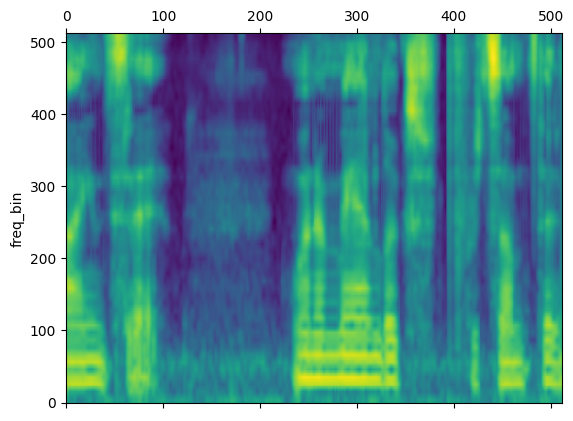

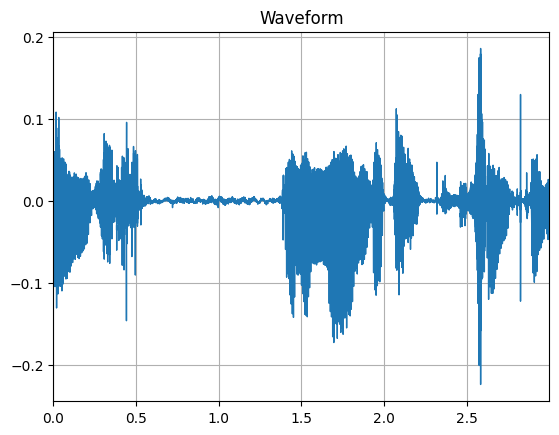

In [10]:
# convert into dataframe
df = pd.DataFrame(audio_data)
# print(f"df: {df}")
num_classes = df[label_column].nunique()
print(f"num_classes: {num_classes}")

dataset = MySpecgramDataset(df, label_column, num_classes, mel = True)
print(f"dataset: {dataset}")

# # Example: Iterate through the dataset
# for i in range(len(dataset)):
#     sample = dataset[i]
#     print(sample['recording_label'], sample[label_column])

# # Example: Decode a label
# sample_label = dataset[22][label_column]
# print(f"sample_label: {sample_label}")
# decoded_label = dataset.decode_label(sample_label)
# print(f"Original label: {decoded_label}")

# Split the dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for batching and shuffling
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# Example: Iterate through the train DataLoader
for batch in train_dataloader:
    print(batch['recording_label'], batch[label_column])
    plot_spectrogram(batch['signal'][0])
    plot_waveform(batch['audio'][0], 16000, title="Waveform", ax=None)
    # for i in range(1,2):
    #     plot_spectrogram(batch['signal'][i])
    #     plot_waveform(batch['audio'][i], 16000, title="Waveform", ax=None)
    print("the shape is: ", batch['signal'][0].shape)
    print("the size is: ", batch['signal'].shape)
    break

In [11]:
from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152, vgg16, vgg19, inception_v3

model = resnet50(pretrained = True)# Modify the first convolutional layer to accept single-channel input

model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, num_classes)  # Assuming num_classes is defined



In [12]:
# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
# Optimizer and Loss Function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training Loop
num_epochs = 20
best_val_acc = 0
save_path = f'./save/RES_{traversal_window_frame}_{traversal_rate}_{filter_label}_{label_column}.pth'

def eval(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    acc = 0       # Initialize the accuracy counter
    total = 0     # Initialize the total number of samples
    with torch.no_grad():  # Disable gradient calculation
        for batch in dataloader:  # Iterate over the dataloader
            signal = batch['signal'].to(device)  # Move input to the appropriate device
            labels = batch[label_column].to(device)  # Move labels to the appropriate device

            outputs = model(signal.unsqueeze(1))  # Ensure input shape is correct for the model
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            _, true_labels = torch.max(labels, 1)  # Get the index of the true labels
            
            acc += (predicted == true_labels).sum().item()  # Update the accuracy counter
            total += labels.size(0)  # Update the total number of samples

    return acc / total  # Return the accuracy as a percentage


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        signals = batch['signal'].to(device)
        labels = batch[label_column].to(device)

        outputs = model(signals.unsqueeze(1))  # Add channel dimension
        loss = criterion(outputs, labels.argmax(dim=1))
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_acc = eval(model, train_dataloader, device)
    val_acc = eval(model, val_dataloader, device)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print(f'Model saved at epoch {epoch+1} with val_acc: {val_acc:.4f}')

KeyboardInterrupt: 

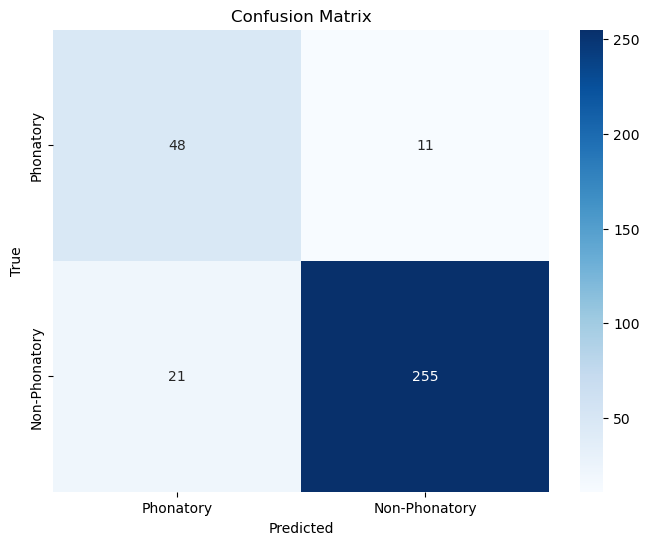

Classification Report:
                precision    recall  f1-score   support

    Phonatory     0.6957    0.8136    0.7500        59
Non-Phonatory     0.9586    0.9239    0.9410       276

     accuracy                         0.9045       335
    macro avg     0.8271    0.8687    0.8455       335
 weighted avg     0.9123    0.9045    0.9073       335



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_predictions_and_labels(model, dataloader, device):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            signal = batch['signal'].to(device)
            outputs = model(signal.view(-1, 1, signal.size(1), signal.size(2)).to(device))
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = torch.argmax(batch[label_column], dim=1).cpu().numpy()  # Convert one-hot encoded labels to class indices
            all_preds.extend(preds)
            all_labels.extend(labels)
    return all_preds, all_labels

# Assuming test_dataloader is defined and model is trained
model.load_state_dict(torch.load(f'./save/ViT_{traversal_window_frame}_{traversal_rate}_{filter_label}_{label_column}.pth'))

# Get predictions and true labels for the test set
preds, labels = get_predictions_and_labels(model, test_dataloader, device)

# Compute confusion matrix and classification report
conf_matrix = confusion_matrix(labels, preds)
class_report = classification_report(labels, preds, target_names=dataset.unique_labels, digits=4)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.unique_labels, yticklabels=dataset.unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print('Classification Report:\n', class_report)

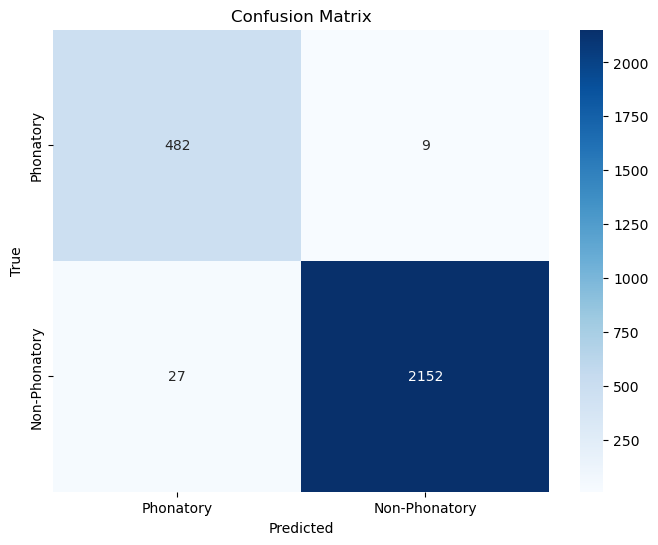

Classification Report:
                precision    recall  f1-score   support

    Phonatory     0.9470    0.9817    0.9640       491
Non-Phonatory     0.9958    0.9876    0.9917      2179

     accuracy                         0.9865      2670
    macro avg     0.9714    0.9846    0.9779      2670
 weighted avg     0.9868    0.9865    0.9866      2670



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_predictions_and_labels(model, dataloader, device):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            signal = batch['signal'].to(device)
            outputs = model(signal.view(-1, 1, signal.size(1), signal.size(2)).to(device))
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = torch.argmax(batch[label_column], dim=1).cpu().numpy()  # Convert one-hot encoded labels to class indices
            all_preds.extend(preds)
            all_labels.extend(labels)
    return all_preds, all_labels

# Assuming test_dataloader is defined and model is trained
model.load_state_dict(torch.load(f'./save/ViT_{traversal_window_frame}_{traversal_rate}_{filter_label}_{label_column}.pth'))

# Get predictions and true labels for the test set
preds, labels = get_predictions_and_labels(model, train_dataloader, device)

# Compute confusion matrix and classification report
conf_matrix = confusion_matrix(labels, preds)
class_report = classification_report(labels, preds, target_names=dataset.unique_labels, digits=4)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.unique_labels, yticklabels=dataset.unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print('Classification Report:\n', class_report)